In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Decision Tree library
from sklearn.tree import DecisionTreeClassifier

# Libraries to scale the data
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

from sklearn import ensemble

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

### Analysis on K-means Imputed and Outlier handled dataset

In [2]:
df1 = pd.read_csv("../processed-datasets/data_outliers_handled_knn_imputed.csv")

In [3]:
df1.head()

,Unnamed: 0,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
0,0,222.0,0.0,7.88,0.050,10.500,0.050,4.25000,11.60000,1.99000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2737.00000,12390.0,305.0,134.0
1,1,222.0,0.0,10.90,1.555,61.505,0.725,7.74125,12.56125,2.64375,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12591.0,503.0,272.0
2,2,222.0,0.0,6.00,0.020,25.100,0.300,4.41000,12.56125,2.30000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12724.0,639.0,414.0
3,3,222.0,0.0,9.06,0.280,12.000,0.070,1.88000,5.08000,1.01000,...,194.00000,83.0000,356.00000,89.5000,762.000,144.00000,1832.00000,12894.0,308.0,127.0
4,4,222.0,0.0,4.93,0.070,16.500,0.150,2.32000,8.23000,1.52000,...,257.00000,106.1375,437.54375,97.8675,936.000,171.00000,2355.00000,12535.0,348.0,155.0


In [4]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df1.sample(5)

,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,Gd,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
1903,3.8000,1.0,11.60,0.000,5.66,0.06,0.61,1.62,0.87,7.19,...,32.20,14.07,79.40,18.87,208.20,50.50,464.70,6900.00,55.800,32.4000
832,839.3875,0.0,16.37,0.110,10.52,0.34,4.67,7.91,0.42,36.83,...,137.49,48.73,219.06,43.82,377.71,67.07,595.02,11432.64,1142.375,479.3000
1838,3.7000,1.0,5.80,0.010,3.98,0.02,0.54,1.03,0.39,7.08,...,33.20,13.00,74.10,17.40,177.00,45.20,452.00,8770.00,22.900,16.5000
1372,112.0000,0.0,2.80,1.555,16.20,0.72,3.66,2.75,0.08,12.20,...,62.80,24.30,117.00,25.00,240.00,43.00,776.00,7041.00,280.000,222.0000
1393,103.0000,0.0,7.70,1.555,14.80,0.69,3.97,5.95,0.05,37.00,...,220.00,91.00,422.00,94.10,842.00,155.00,2512.00,10928.00,1142.375,701.7125


In [6]:
X = df1.drop('Feature', axis=1).values
y = df1.Feature.values

### Splitting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Scaling the data using Standard Scaler

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(2390, 20)

### Fitting the base model

In [10]:
tree = DecisionTreeClassifier()

tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [11]:
y_pred = tree.predict(X_test_scaled)

In [12]:
print("Accuracy of test data over base model: ", round(accuracy_score(y_test, y_pred), 2))

Accuracy of test data over base model:  0.92


In [13]:
print("Classification report of test data over base model: \n\n", classification_report(y_test, y_pred))

Classification report of test data over base model: 

               precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       349
         1.0       0.94      0.87      0.90       249

    accuracy                           0.92       598
   macro avg       0.92      0.91      0.92       598
weighted avg       0.92      0.92      0.92       598



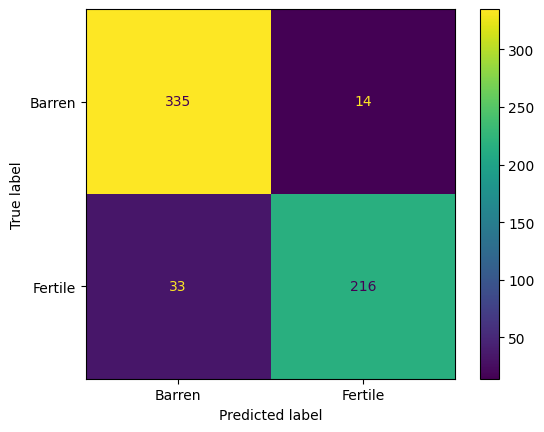

In [14]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Hyper Parameter Tuning - Bayesian Optimization

In [15]:
def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    model = DecisionTreeClassifier(**params)
    kfold = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []
    
    for idx in kfold.split(X=x, y=y):
        train_idx, valid_idx = idx[0], idx[1]        
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xvalid = x[valid_idx]
        yvalid = y[valid_idx]
        
        model.fit(xtrain, ytrain)        
        preds = model.predict(xvalid)        
        fold_accuracy = accuracy_score(yvalid, preds)
        
        accuracies.append(fold_accuracy)
        
    return -1.0 * np.mean(accuracies)

In [16]:
param_space = [
    space.Integer(3, 10, name='max_depth'),
    space.Categorical(['best', 'random'], name='splitter'),
    space.Categorical(['gini', 'entropy', 'log_loss'], name='criterion'),
    space.Categorical(['sqrt', 'log2'], name='max_features')
]

In [17]:
param_names = ['max_depth', 'splitter', 'criterion',  'max_features']

In [18]:
optimization_function = partial(optimize, param_names = param_names, x = X_train_scaled, y = y_train)

In [19]:
result = gp_minimize(func=optimization_function,
                     dimensions = param_space,
                     n_calls=20,
                     n_random_starts=5,
                     verbose=10,
                     n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0236
Function value obtained: -0.7983
Current minimum: -0.7983
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0259
Function value obtained: -0.8351
Current minimum: -0.8351
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0077
Function value obtained: -0.7757
Current minimum: -0.8351
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0061
Function value obtained: -0.7339
Current minimum: -0.8351
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.7334
Function value obtained: -0.7778
Current minimum: -0.8351
Iteration No: 6 started. 

/opt/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'best', 'gini', 'sqrt'] before, using random point [7, 'random', 'gini', 'log2']
  warnings.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5264
Function value obtained: -0.7946
Current minimum: -0.9029
Iteration No: 19 started. Searching for the next optimal point.


/opt/miniconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'best', 'gini', 'sqrt'] before, using random point [3, 'best', 'log_loss', 'log2']
  warnings.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4804
Function value obtained: -0.7678
Current minimum: -0.9029
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5626
Function value obtained: -0.8510
Current minimum: -0.9029


In [20]:
best_params = dict(zip(param_names, result.x))
print(best_params)

{'max_depth': 10, 'splitter': 'best', 'criterion': 'gini', 'max_features': 'sqrt'}


In [21]:
best_model_tree = DecisionTreeClassifier(**best_params)

best_model_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt')

In [22]:
y_pred_best = best_model_tree.predict(X_test_scaled)

In [23]:
print("Accuracy of test data using Bayesian Optimization: ", round(accuracy_score(y_test, y_pred_best), 2))

Accuracy of test data using Bayesian Optimization:  0.9


In [24]:
print("Classification report for test data: \n\n", classification_report(y_test, y_pred_best))

Classification report for test data: 

               precision    recall  f1-score   support

         0.0       0.92      0.91      0.91       349
         1.0       0.87      0.89      0.88       249

    accuracy                           0.90       598
   macro avg       0.89      0.90      0.90       598
weighted avg       0.90      0.90      0.90       598



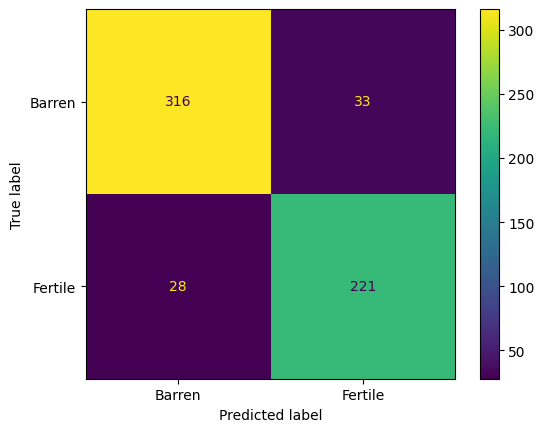

In [25]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Hyper-Parameter Tuning - Grid search CV

In [26]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [27]:
param_grid = {
    'max_depth': np.arange(3, 11, 1),
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

In [28]:
clf = GridSearchCV(estimator=DecisionTreeClassifier(),
                   param_grid=param_grid,
                   scoring='accuracy',
                   verbose=10,
                   n_jobs=-1,
                   return_train_score=True
                  )

In [29]:
clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                         'max_features': ['sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='accuracy', verbose=10)

In [30]:
clf.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2')

In [31]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'splitter': 'best'}

In [32]:
clf.best_score_

0.896234309623431

In [33]:
best_model_tree = DecisionTreeClassifier(**best_params)

best_model_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt')

In [34]:
y_pred_best = best_model_tree.predict(X_test_scaled)

In [35]:
print("Accuracy of test data using Bayesian Optimization: ", round(accuracy_score(y_test, y_pred_best), 2))

Accuracy of test data using Bayesian Optimization:  0.92


In [36]:
print("Classification report for test data: \n\n", classification_report(y_test, y_pred_best))

Classification report for test data: 

               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       349
         1.0       0.90      0.91      0.91       249

    accuracy                           0.92       598
   macro avg       0.92      0.92      0.92       598
weighted avg       0.92      0.92      0.92       598



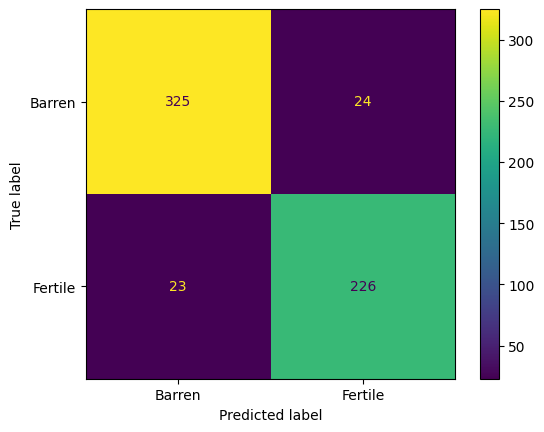

In [37]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot()

### Plotting the decision boundary

In [38]:
input_features = X_test_scaled.copy()
output_feature = y_test.copy()

In [39]:
pca = PCA(n_components = 2)

X_reduced = pca.fit_transform(input_features)

In [40]:
X_reduced.shape

(598, 2)

In [41]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [42]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [43]:
plot_model = DecisionTreeClassifier(**best_params)

plot_model.fit(X_reduced, output_feature)

DecisionTreeClassifier(max_depth=10, max_features='sqrt')

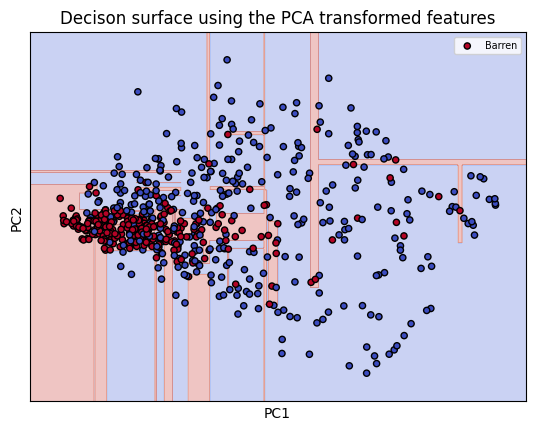

In [44]:
fig, ax = plt.subplots(facecolor='white')

# title for the plots
title = ('Decision surface of Tuned SVC ')

# Set-up grid for plotting.
X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, plot_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3) # alpha=0.8
ax.scatter(X0, X1, c=y_test, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed features')
ax.legend(labels=['Barren', 'Fertile'], fontsize="x-small")
plt.show()